# Parameters

In [1]:
num_of_epochs = 10
batch_size = 32
dataset_name = 'plantVillage-tomato-mohanty'
dataset_path = '../datasets/' + dataset_name
model_diagram_path = 'alexnet_model_diagram.png'
model_save_path = 'alexnet_' + dataset_name +'.h5'


# Load dataset

In [2]:
import sys, os
sys.path.append('..')
import numpy as np
from imutils import paths



from utils.preprocessors.aspect_aware_preprocessor import AspectAwarePreprocessor
from utils.preprocessors.image_to_array_preprocessor import ImageToArrayPreprocessor
from utils.io.simple_dataset_loader import SimpleDatasetLoader

# Get the list of image names
image_paths = list(paths.list_images(dataset_path))

print(len(image_paths), 'images loaded')

# Get unique class_names
class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
class_names = [str(x) for x in np.unique(class_names)]
print(class_names)


# Preprocessors
aap = AspectAwarePreprocessor(227, 227)
itap = ImageToArrayPreprocessor()

# Add preprocessors to DataSetLoader class
sdl = SimpleDatasetLoader(preprocessors=[aap, itap])

(data, labels) = sdl.load(image_paths, verbose=500)
data = data.astype('float') / 255.0



Using TensorFlow backend.


18160 images loaded
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
[INFO]: Processed 500/18160
[INFO]: Processed 1000/18160
[INFO]: Processed 1500/18160
[INFO]: Processed 2000/18160
[INFO]: Processed 2500/18160
[INFO]: Processed 3000/18160
[INFO]: Processed 3500/18160
[INFO]: Processed 4000/18160
[INFO]: Processed 4500/18160
[INFO]: Processed 5000/18160
[INFO]: Processed 5500/18160
[INFO]: Processed 6000/18160
[INFO]: Processed 6500/18160
[INFO]: Processed 7000/18160
[INFO]: Processed 7500/18160
[INFO]: Processed 8000/18160
[INFO]: Processed 8500/18160
[INFO]: Processed 9000/18160
[INFO]: Processed 9500/18160
[INFO]: Processed 10000/18160
[INFO]: Processed 10500/18160
[INFO]: Processed 11000/18160
[INFO]: Processed 11500/18160
[INFO]: Proce

# Encode labels and split dataset

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels,
test_size=0.25, random_state=0)

# Convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

# Initialize model

In [4]:
# os.environ["PATH"] += os.pathsep + 'C:/anaconda3/Lib/site-packages/graphviz-2.38/bin'


print(os.environ["PATH"])

/usr/local/cuda/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games


In [5]:
import os, sys
# import pydot_ng as pydot
# pydot.find_graphviz()
# os.environ.get('PATH', '')

# remove these
# sys.path.append('..')
# class_names = ['one', 'two', 'three', 'four']
# remove these

from utils.models.alexnet import alexnet
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD

model = alexnet(len(class_names))
model.summary()

# plot_model(model, to_file=model_diagram_path, show_shapes=True)

# copile model
opt = SGD(lr=0.05)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

# Fit model

In [6]:
# train the network
print("[INFO] training network...")
H = model.fit(train_x, train_y, validation_data=(test_x, test_y),
              batch_size=batch_size, epochs=num_of_epochs, verbose=1)

model.save(model_save_path)

[INFO] training network...
Train on 13620 samples, validate on 4540 samples
Epoch 1/10
13620/13620 [==============================] - 534s 39ms/step - loss: 2.1041 - accuracy: 0.2930 - val_loss: 2.0682 - val_accuracy: 0.2998
Epoch 2/10
13620/13620 [==============================] - 517s 38ms/step - loss: 1.8342 - accuracy: 0.3587 - val_loss: 1.8659 - val_accuracy: 0.4121
Epoch 3/10
13620/13620 [==============================] - 519s 38ms/step - loss: 1.4969 - accuracy: 0.4910 - val_loss: 1.7199 - val_accuracy: 0.3910
Epoch 4/10
13620/13620 [==============================] - 520s 38ms/step - loss: 1.2835 - accuracy: 0.5672 - val_loss: 1.0247 - val_accuracy: 0.6579
Epoch 5/10
13620/13620 [==============================] - 520s 38ms/step - loss: 1.0636 - accuracy: 0.6388 - val_loss: 0.9842 - val_accuracy: 0.6846
Epoch 6/10
13620/13620 [==============================] - 518s 38ms/step - loss: 0.8993 - accuracy: 0.6975 - val_loss: 0.7299 - val_accuracy: 0.7493
Epoch 7/10
13620/13620 [======

# Generate classfication report

In [7]:
print(class_names)
print(H)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [8]:
from sklearn.metrics import classification_report


# If one hot encoding is used
predictions = model.predict(test_x, batch_size=batch_size)
print(classification_report(test_y.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))


                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.00      0.00      0.00       572
                        Tomato___Early_blight       0.00      0.00      0.00       239
                         Tomato___Late_blight       0.00      0.00      0.00       446
                           Tomato___Leaf_Mold       0.00      0.00      0.00       231
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00       425
Tomato___Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00       401
                         Tomato___Target_Spot       0.00      0.00      0.00       345
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.30      1.00      0.46      1360
                 Tomato___Tomato_mosaic_virus       0.00      0.00      0.00       102
                             Tomato___healthy       0.00      0.00      0.00       419

                                  avg / t

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot model

ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

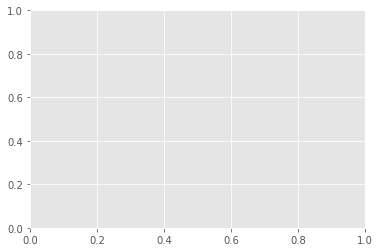

In [9]:
# plot the training loss and accuracy
from matplotlib import pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(args["output"])
plt.show()

In [ ]:
import os
print(os.path.exists('/usr/bin/dot'))